# Данные для обучения

In [1]:
import pandas as pd
import re

In [44]:
# Загружаем данные (взяты с Kaggle)
data_house_s1 = pd.read_csv('data/dr.House_season1.csv', encoding='unicode_escape')
data_house_s2 = pd.read_csv('data/dr.House_season2.csv', encoding='unicode_escape')
data_house_s3 = pd.read_csv('data/dr.House_season3.csv', encoding='unicode_escape')
data_house_s4 = pd.read_csv('data/dr.House_season4.csv', encoding='unicode_escape')

In [45]:
data_house_s1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9796 entries, 0 to 9795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    9796 non-null   object
 1   line    9796 non-null   object
dtypes: object(2)
memory usage: 153.2+ KB


In [46]:
data_house_s2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10703 entries, 0 to 10702
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    10703 non-null  object
 1   line    10703 non-null  object
dtypes: object(2)
memory usage: 167.4+ KB


In [47]:
data_house = pd.concat([data_house_s1, data_house_s2, data_house_s3, data_house_s4], axis=0, ignore_index=True)

In [48]:
# Примеры данных
data_house.sample(6)

name                                               line
34576    House   ... with sParkly things like four-carat diamo...
1912   Foreman   Isn't the prognosis for Churg-Strauss a bit g...
37325   Kutner   And coaches handicapped kids. You think we sh...
27469   Wilson   All right, you're going to feel a little burn...
27745  Cameron   That no one in his family has Ever been diagn...
34734    House   You think that just because she's as beautifu...

In [49]:
data_house.head()

name                                               line
0  Melanie                                  Why are you late?
1  Rebecca               You're not going to like the answer.
2  Melanie                         I already know the answer.
3  Rebecca                                  I missed the bus.
4  Melanie   I don't doubt it, no bus stops near Brad's. Y...

In [50]:
data_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39083 entries, 0 to 39082
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    39083 non-null  object
 1   line    39083 non-null  object
dtypes: object(2)
memory usage: 610.8+ KB


Внимательно посмотрев данные можно заметить, что в них присутсвуют лишние неизвестные символы, а так же информация описывающая происходящее вокруг в квадратных скобках. Необходимо очистить данные.

In [51]:
data_house.line[826]

' "D"\x9d, see ya. [Crosses out the "D"\x9d] "N"\x9d for neoplastic?'

In [52]:
# Пример неправильных данных
data_house.line[826]

' "D"\x9d, see ya. [Crosses out the "D"\x9d] "N"\x9d for neoplastic?'

In [53]:
# Функция очистки
def clear_text(text):
    out = re.sub(r'\[[^\]]+\]', '', text)
    out = out.replace('\x9d', '')
    return out

In [54]:
data_house.line = data_house.line.map(clear_text)

In [55]:
# Пример обработанных данных
data_house.line[826]

' "D", see ya.  "N" for neoplastic?'

In [56]:
# Выбираем персонажа на которого должен быть похож наш чат бот. Это будет доктор Хаус
CHARACTER_NAME = 'House'

In [57]:
data_house[data_house.name == CHARACTER_NAME].index

Index([   33,    35,    37,    39,    41,    43,    45,    47,    49,    51,
       ...
       39012, 39061, 39063, 39065, 39067, 39069, 39071, 39074, 39076, 39078],
      dtype='int64', length=12539)

In [ ]:
contexted = []

# будем учитывать контекс диалога, глубиной = 2
n = 2

for i in data_house[data_house.name == CHARACTER_NAME].index:
  if i < n:
    continue
  row = []
  prev = i - 1 - n # we additionally substract 1, so row will contain current responce and 7 previous responces
  for j in range(i, prev, -1):
    row.append(data_house.line[j])
  contexted.append(row)

columns = ['response', 'context']
columns = columns + ['context/' + str(i) for i in range(n - 1)]

df_house = pd.DataFrame.from_records(contexted, columns=columns)

In [ ]:
df_house.sample(6)


response  \
2267                        So how can I work with you?   
1123                 Well, let's do an MRI of our own.    
682    Checked the blood lEvels. And it's not eosino...   
633    I thought that was a job requirement for you ...   
2472   No, but it does tell us something. Though I h...   
2268                              I am selling my soul.   

                                                context  \
2267                                              Yeah.   
1123                      No, because the MRI showed "   
682    Well, it could be mast-cell leukemia. It can ...   
633    I need to talk with you, Dr. House. Sister Au...   
2472   Oh. Well, we can burn off the swollen blood v...   
2268                                         I hope so.   

                                              context/0  
2267   I can't fire you, so you have no reason to fe...  
1123   Uncommon, but it fits. It's also treatable. D...  
682                   Checked that. Checked Everything.  
633    House of prayer, huh. That explains the good ...  
2472                                There? A Dieulafoy?  
2268                                Am I gonna be okay?

# Дообучение модели DialoGPT


## Setup

In [ ]:
!pip install -U scikit-learn scipy matplotlib
!pip install tensorboardX

In [47]:
# all the imports

import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AutoConfig,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

## Подготовка данных для обучения данной модели

In [48]:
trn_df, val_df = train_test_split(df_house, test_size=0.2)
trn_df.head()

response  \
1097   They will. Maybe tomorrow, maybe the day afte...   
407                  No, it wasn't. Where's the bottle?   
2716   Well, lock him in a cage. That should be fine...   
999    I'm not sure about gastroenteritis but mental...   
1222      What, you gonna charge me with assault again?   

                                                context  \
1097                      The CDC promised they'd call.   
407                         It was just cough medicine!   
2716   It's not about pain. It's about being open, b...   
999    Source of botulism, as well as a million othe...   
1222                           You just touched my leg.   

                                              context/0  
1097   Thought I'd hang out in case you change your ...  
407                                   They're all gone?  
2716   Yeah, he is. A little. But it's got to stop. ...  
999    Matt decided to make himself a homemade pizza...  
1222                                              What?

In [49]:
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2428 entries, 1097 to 860
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   response   2428 non-null   object
 1   context    2428 non-null   object
 2   context/0  2428 non-null   object
dtypes: object(3)
memory usage: 75.9+ KB


In [50]:
# Создание датасета для обучения модели
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [51]:
# Кэширование и хранение данных/контрольных точек

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

## Загрузка модели

In [52]:
from transformers import AutoModelWithLMHead, AutoModelForCausalLM, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-medium")

C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\auto\modeling_auto.py:1362: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
#Можно попробовать поговорить с базовой моделью
for step in range(5):
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

In [ ]:
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [ ]:
# Создадим класс для хранения всех параметров
class Args():
    def __init__(self):
        self.output_dir = 'output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-medium'
        self.config_name = 'microsoft/DialoGPT-medium'
        self.tokenizer_name = 'microsoft/DialoGPT-medium'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 5
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

## Обучение модели DialoGPT

In [ ]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )


    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):

        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)


    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)


    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args) 
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  

            if args.n_gpu > 1:
                loss = loss.mean() 
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"

                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    ) 
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step



def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:

    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)


    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )


    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)


    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [ ]:
def main(df_trn, df_val):
    args = Args()

    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )


    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device


    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )


    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)

    logger.info("Training/evaluation parameters %s", args)


    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)


    if args.do_train:
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        model_to_save = (
            model.module if hasattr(model, "module") else model
        ) 
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [46]:
#Запуск обучения
main(trn_df, val_df)

03/03/2024 18:25:02 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/03/2024 18:25:05 - INFO - __main__ -   Training/evaluation parameters <__main__.Args object at 0x0000018114C63650>
03/03/2024 18:25:05 - INFO - __main__ -   Creating features from dataset file at cached
03/03/2024 18:25:06 - INFO - __main__ -   Saving features into cached file cached\gpt2_cached_lm_512
03/03/2024 18:25:06 - INFO - __main__ -   ***** Running training *****
03/03/2024 18:25:06 - INFO - __main__ -     Num examples = 2428
03/03/2024 18:25:06 - INFO - __main__ -     Num Epochs = 5
03/03/2024 18:25:06 - INFO - __main__ -     Instantaneous batch size per GPU = 4
03/03/2024 18:25:06 - INFO - __main__ -     Total train batch size (w. parallel, distributed & accumulation) = 4
03/03/2024 18:25:06 - INFO - __main__ -     Gradient Accumulation steps = 1
03/03/2024 18:25:06 - INFO - __main__ -     Total optimization steps = 3035


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/607 [00:00<?, ?it/s]

Iteration:   0%|          | 0/607 [00:00<?, ?it/s]

Iteration:   0%|          | 0/607 [00:00<?, ?it/s]

Iteration:   0%|          | 0/607 [00:00<?, ?it/s]

Iteration:   0%|          | 0/607 [00:00<?, ?it/s]

03/03/2024 20:05:52 - INFO - __main__ -    global_step = 3035, average loss = 1.6189230048479712
03/03/2024 20:05:52 - INFO - __main__ -   Saving model checkpoint to output-small
03/03/2024 20:05:58 - INFO - __main__ -   Evaluate the following checkpoints: ['output-small']
03/03/2024 20:06:01 - INFO - __main__ -   Creating features from dataset file at cached
03/03/2024 20:06:01 - INFO - __main__ -   Saving features into cached file cached\gpt2_cached_lm_512
03/03/2024 20:06:01 - INFO - __main__ -   ***** Running evaluation  *****
03/03/2024 20:06:01 - INFO - __main__ -     Num examples = 607
03/03/2024 20:06:01 - INFO - __main__ -     Batch size = 4


Evaluating:   0%|          | 0/151 [00:00<?, ?it/s]

03/03/2024 20:06:19 - INFO - __main__ -   ***** Eval results  *****
03/03/2024 20:06:19 - INFO - __main__ -     perplexity = tensor(7.1845)


{'perplexity_': tensor(7.1845)}

## Push Model to Hugging Face

In [56]:
MY_MODEL_NAME = 'DialoGPT-medium-Dr-House'

In [ ]:
model.push_to_hub(MY_MODEL_NAME)
tokenizer.push_to_hub(MY_MODEL_NAME)

## Загрузка обученой иодели

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('pivovalera2012/DialoGPT-medium-Dr-House')
model = AutoModelWithLMHead.from_pretrained('pivovalera2012/DialoGPT-medium-Dr-House')

In [62]:
for step in range(6):

    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        do_sample=True,
        top_k=100,
        top_p=0.7,
        temperature=0.8
    )

    print("House_Bot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


House_Bot: Hi! :D


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


House_Bot: The one and only!


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


House_Bot: Because I need a way to feel better about myself


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


House_Bot: I need a job


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


House_Bot: So they're waiting for me


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


House_Bot: Patient is waiting for him


# Дообучение модели Llama-2

## Подготовка модели и данных

https://www.kaggle.com/code/gunman02/fine-tuning-llama/notebook \
https://www.kaggle.com/code/philculliton/fine-tuning-with-llama-2-qlora/notebook \
https://deci.ai/blog/fine-tune-llama-2-with-lora-for-question-answering/

In [ ]:
!pip install bitsandbytes
!pip install datasets
!pip install accelerate
!pip install peft
!pip install scipy
!pip install git+https://github.com/huggingface/transformers
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install trl

In [33]:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer
from peft import prepare_model_for_kbit_training
import torch
from peft import LoraConfig, get_peft_model
from datasets import Dataset
import transformers
torch.cuda.is_available()

True

In [34]:
MODEL_NAME = 'meta-llama/Llama-2-7b-chat-hf'

Для использования модели [LLama](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf) необходимо запростить доступ на сайте Meta. После получения разрешения логинимся в huggingface и получаем доступ

In [36]:
from huggingface_hub import interpreter_login
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token can be pasted using 'Right-Click'.
Token is valid (permission: write).
Your token has been saved to C:\Users\PVA\.cache\huggingface\token
Login successful


In [37]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)

device_map = {
    "transformer.word_embeddings": 0,
    "transformer.word_embeddings_layernorm": 0,
    "lm_head": 0,
    "transformer.h": 0,
    "transformer.ln_f": 0,
    "model.embed_tokens": 0,
    "model.layers": 0,
    "model.norm": 0
}

In [ ]:
# Загружаем модель
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map=device_map,
    trust_remote_code=True,
    quantization_config=bnb_config,
)

In [39]:
# Загружаем токенайзер
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Используем оболочку PEFT для настройки нашей модели для обучения.
model = prepare_model_for_kbit_training(model)

In [ ]:
# Определяем некоторые вспомогательные функции для идентификации наших слоев обновления
import re
def get_num_layers(model):
    numbers = set()
    for name, _ in model.named_parameters():
        for number in re.findall(r'\d+', name):
            numbers.add(int(number))
    return max(numbers)

def get_last_layer_linears(model):
    names = []

    num_layers = get_num_layers(model)
    for name, module in model.named_modules():
        if str(num_layers) in name and not "encoder" in name:
            if isinstance(module, torch.nn.Linear):
                names.append(name)
    return names

In [25]:
# Определяем конфигурацию LoRa для значительного сокращения количества параметров, которые необходимо точно настроить.
config = LoraConfig(
    r=2,
    lora_alpha=32,
    target_modules=get_last_layer_linears(model),
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [27]:
# Создаем датасет для обучения
dataset_train_house = Dataset.from_pandas(df_house)
dataset_train_house

In [ ]:
# Настраеваме промпт для модели
def generate_prompt(data_point):
    return f"""
            {data_point["context/0"]} {data_point["context"]}
            Answer like Dr. House: {data_point["response"]}
            """.strip()


def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
    return tokenized_full_prompt

data = dataset_train_house.shuffle().map(generate_and_tokenize_prompt)

## Обучение модели Llama-2

In [ ]:
training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=1e-4,
    fp16=True,
    output_dir="finetune_Llama_DrHouse",
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.01,
    report_to="none",
    logging_steps = 100
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False
trainer.train()

In [35]:
# Сохраняем дообученую модель
model.save_pretrained("trained_model_Llama_Dr_House")

In [ ]:
# Сохранение дообученой модели на Hugging Face
model.push_to_hub('Llama-2-7b-Dr-House')
tokenizer.push_to_hub('Llama-2-7b-Dr-House')

[Ссылка](https://huggingface.co/pivovalera2012/Llama-2-7b-Dr-House) на дообученую модель на hugging face

### Пример генерации модели

In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 70
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [100]:
prompt = "What is the universe? Answer like Dr. House: ".strip() # Вопрос про вселенную
device = "cuda"

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model.generate(
        input_ids = encoding.input_ids,
        attention_mask = encoding.attention_mask,
        generation_config = generation_config
    )

answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = answer.split(':')
print(answer[1])

  It's a big, cold, empty place. It's not a question of what it is, it's a question of what we want it to be.  And right now, I want it to be a place where I can find the next Vicodin.  You know, for my leg.
            Answer like


## Загрузка дообученой модели и генерация ответов

In [2]:
from peft import PeftModel
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

In [5]:
MODEL_NAME = 'meta-llama/Llama-2-7b-chat-hf' # Основная модель
ADAPTERS_NAME = 'pivovalera2012/Llama-2-7b-Dr-Hous-test' # Дообученые веса модели

In [3]:
device_map = {
    "transformer.word_embeddings": 0,
    "transformer.word_embeddings_layernorm": 0,
    "lm_head": 0,
    "transformer.h": 0,
    "transformer.ln_f": 0,
    "model.embed_tokens": 0,
    "model.layers": 0,
    "model.norm": 0
}
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)

In [6]:
model_trained = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map=device_map,
    trust_remote_code=True,
    quantization_config=bnb_config,
)

bin C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bitsandbytes\libbitsandbytes_cuda121.dll


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [7]:
model_trained = PeftModel.from_pretrained(model_trained, 'trained_model_Llama_Dr_House_v3')
model_trained = model_trained.merge_and_unload()

C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\peft\tuners\lora\bnb.py:249: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

In [8]:
generation_config = model_trained.generation_config
generation_config.max_new_tokens = 100
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [42]:
prompt = "We need to do an MRI scan on him otherwise he will die. Answer like Dr. House: ".strip()

In [43]:
#Примеры генерации ответов

device = "cuda"
encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model_trained.generate(
        input_ids = encoding.input_ids,
        attention_mask = encoding.attention_mask,
        generation_config = generation_config
    )

answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
#answer = answer.split(':')
#print(answer[1])
print(answer)

We need to do an MRI scan on him otherwise he will die. Answer like Dr. House:

"MRI? Oh, please. That's like the first thing that comes to mind when you hear the word 'death'. Like, 'Oh no, we need to do an MRI scan or he'll die!' No, no, no. I've seen plenty of patients who've died without ever getting an MRI scan. It's not like that's the magic bullet. Although, I suppose it could be useful in determining the cause


In [11]:

device = "cuda"
for step in range(6):

    print("User: ")
    prompt = input(">> User:")
    print(prompt)
    prompt = prompt + ' ' + 'Answer like Dr. House: '
    encoding = tokenizer(prompt.strip(), return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model_trained.generate(
            input_ids = encoding.input_ids,
            attention_mask = encoding.attention_mask,
            generation_config = generation_config
        )
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = answer.split(':')
    print("House_Bot: {}".format(answer[1]))

User: 
Why is the grass green?
House_Bot: 

"Well, that's a bloody good question, isn't it? *coughs* *scratches chin* Now, let me think... *pauses* Hmmm... I believe the grass is green because... *looks up* Oh, I know! It's because of the chlorophyll! *winks* Yes, that's right! Chlorophyll, the magical pigment that absorbs sun
User: 
Why is the grass green?
House_Bot: 

"Well, that's a damn good question. I mean, why is anything green? Why is the sky blue? Why is the sun yellow? Why is the grass green? It's all just a goddamn mystery, isn't it?

"But let me tell you something, my dear, the grass is green because of a little thing called chlorophyll. It's a magical molecule that absorbs light and converts it
User: 



KeyboardInterrupt: 

##  Обучение с специальным промптом для Llama-2

### Подготовка данных

In [1]:
from datasets import Dataset
from transformers import TrainingArguments
from peft import prepare_model_for_kbit_training
from trl import SFTTrainer

In [58]:
contexted = []

# окно контекста = 3
n = 3

for i in data_house[data_house.name == CHARACTER_NAME].index:
  if i < n:
    continue

  if data_house.name[i-2] == CHARACTER_NAME and data_house.name[i-1] != CHARACTER_NAME and data_house.name[i-3] != CHARACTER_NAME:
    contexted.append(f'{tokenizer.bos_token}[INST] {data_house.line[i-3]} [/INST] {data_house.line[i-2]} {tokenizer.eos_token} {tokenizer.bos_token}[INST] {data_house.line[i-1]} [/INST] {data_house.line[i]}{tokenizer.eos_token}')
  elif data_house.name[i-1] == CHARACTER_NAME and data_house.name[i-2] != CHARACTER_NAME:
    contexted.append(f'{tokenizer.bos_token}[INST] {data_house.line[i-2]} [/INST] {data_house.line[i-1]} {data_house.line[i]}{tokenizer.eos_token}')
  else:
    contexted.append(f'{tokenizer.bos_token}[INST] {data_house.line[i-1]} [/INST] {data_house.line[i]} {tokenizer.eos_token}')

df_house_v2 = pd.DataFrame(contexted, columns=['text'])

In [59]:
display(df_house_v2.text[50])
display(df_house_v2.text[100])
display(df_house_v2.text[200])

"<s>[INST]  What's that? What are you doing? [/INST]  Painkillers. </s>"

"<s>[INST]  Yes, yes, her name is Rebecca. I call her Rachel. [/INST]  You idiot! </s> <s>[INST]  Hey!listen! [/INST]  Not you, him! You said you didn't find anything.</s>"

"<s>[INST]  No space-occupying tumors. [/INST]  He's 16, so he should have an absolutely pristine brain. The smallest thing is abnormal. </s> <s>[INST]  Meningeal enhancement. My bet is viral meningitis. [/INST]  Excellent, you see what he did there? He took a small clue that there's a neurological pRoblem and wasn't afraid to run with it.</s>"

In [60]:
df_house_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12539 entries, 0 to 12538
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12539 non-null  object
dtypes: object(1)
memory usage: 98.1+ KB


In [61]:
dataset_v2 = Dataset.from_pandas(df_house_v2)

In [62]:
MODEL_NAME = 'meta-llama/Llama-2-7b-chat-hf'

In [63]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)

device_map = {
    "transformer.word_embeddings": 0,
    "transformer.word_embeddings_layernorm": 0,
    "lm_head": 0,
    "transformer.h": 0,
    "transformer.ln_f": 0,
    "model.embed_tokens": 0,
    "model.layers": 0,
    "model.norm": 0
}

In [64]:
# Загружаем модель
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map=device_map,
    trust_remote_code=True,
    quantization_config=bnb_config,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [65]:
# Загружаем токенайзер
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

In [68]:
# Используем оболочку PEFT для настройки нашей модели для обучения.
model = prepare_model_for_kbit_training(model)

In [69]:
# Определяем некоторые вспомогательные функции для идентификации наших слоев обновления
import re
def get_num_layers(model):
    numbers = set()
    for name, _ in model.named_parameters():
        for number in re.findall(r'\d+', name):
            numbers.add(int(number))
    return max(numbers)

def get_last_layer_linears(model):
    names = []

    num_layers = get_num_layers(model)
    for name, module in model.named_modules():
        if str(num_layers) in name and not "encoder" in name:
            if isinstance(module, torch.nn.Linear):
                names.append(name)
    return names

In [70]:
from peft import LoraConfig, get_peft_model

In [71]:
# Определяем конфигурацию LoRa для значительного сокращения количества параметров, которые необходимо точно настроить.
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=get_last_layer_linears(model),
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

## Дообучение

In [73]:
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=1e-4,
    fp16=True,
    output_dir="finetune_Llama_DrHouse_v3",
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.01,
    report_to="none",
    logging_steps = 100
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_v2,
    args=training_args,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    packing=False
)
model.config.use_cache = False

Map:   0%|          | 0/12539 [00:00<?, ? examples/s]

In [74]:
trainer.train()

  0%|          | 0/6268 [00:00<?, ?it/s]

C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 4.1181, 'grad_norm': 0.5006940364837646, 'learning_rate': 9.999122702422906e-05, 'epoch': 0.03}
{'loss': 2.6492, 'grad_norm': 0.7941417694091797, 'learning_rate': 9.9879767138019e-05, 'epoch': 0.06}
{'loss': 2.5177, 'grad_norm': 0.9539546370506287, 'learning_rate': 9.964047282850401e-05, 'epoch': 0.1}
{'loss': 2.4254, 'grad_norm': 1.303494930267334, 'learning_rate': 9.927395737140312e-05, 'epoch': 0.13}
{'loss': 2.4607, 'grad_norm': 1.0945278406143188, 'learning_rate': 9.878116009131186e-05, 'epoch': 0.16}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.4036, 'grad_norm': 1.0706285238265991, 'learning_rate': 9.816334395435298e-05, 'epoch': 0.19}
{'loss': 2.3765, 'grad_norm': 0.9590988755226135, 'learning_rate': 9.74220923313822e-05, 'epoch': 0.22}
{'loss': 2.3458, 'grad_norm': 1.2870866060256958, 'learning_rate': 9.655930494004424e-05, 'epoch': 0.26}
{'loss': 2.298, 'grad_norm': 1.1419273614883423, 'learning_rate': 9.557719297607906e-05, 'epoch': 0.29}
{'loss': 2.3115, 'grad_norm': 1.1756781339645386, 'learning_rate': 9.447827344635616e-05, 'epoch': 0.32}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.3559, 'grad_norm': 1.1288461685180664, 'learning_rate': 9.326536271816031e-05, 'epoch': 0.35}
{'loss': 2.3347, 'grad_norm': 1.3500564098358154, 'learning_rate': 9.194156930126124e-05, 'epoch': 0.38}
{'loss': 2.3335, 'grad_norm': 1.434709072113037, 'learning_rate': 9.051028588126542e-05, 'epoch': 0.41}
{'loss': 2.3192, 'grad_norm': 1.11580491065979, 'learning_rate': 8.897518062466762e-05, 'epoch': 0.45}
{'loss': 2.3274, 'grad_norm': 1.185276985168457, 'learning_rate': 8.73401877778857e-05, 'epoch': 0.48}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.3363, 'grad_norm': 1.1750296354293823, 'learning_rate': 8.560949758437251e-05, 'epoch': 0.51}
{'loss': 2.3074, 'grad_norm': 1.525639295578003, 'learning_rate': 8.378754554564498e-05, 'epoch': 0.54}
{'loss': 2.3372, 'grad_norm': 1.4209116697311401, 'learning_rate': 8.187900105375373e-05, 'epoch': 0.57}
{'loss': 2.332, 'grad_norm': 1.076099157333374, 'learning_rate': 7.988875542432572e-05, 'epoch': 0.61}
{'loss': 2.3099, 'grad_norm': 1.0986229181289673, 'learning_rate': 7.782190936085003e-05, 'epoch': 0.64}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.3, 'grad_norm': 1.3612825870513916, 'learning_rate': 7.568375988233342e-05, 'epoch': 0.67}
{'loss': 2.32, 'grad_norm': 1.157199501991272, 'learning_rate': 7.347978674782869e-05, 'epoch': 0.7}
{'loss': 2.2891, 'grad_norm': 1.868922472000122, 'learning_rate': 7.121563841262733e-05, 'epoch': 0.73}
{'loss': 2.3252, 'grad_norm': 1.1790268421173096, 'learning_rate': 6.889711755210886e-05, 'epoch': 0.77}
{'loss': 2.2867, 'grad_norm': 1.2500481605529785, 'learning_rate': 6.653016619034695e-05, 'epoch': 0.8}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.3081, 'grad_norm': 1.3661725521087646, 'learning_rate': 6.412085047158575e-05, 'epoch': 0.83}
{'loss': 2.2997, 'grad_norm': 1.1343505382537842, 'learning_rate': 6.16753451136144e-05, 'epoch': 0.86}
{'loss': 2.2942, 'grad_norm': 1.1218340396881104, 'learning_rate': 5.919991758288401e-05, 'epoch': 0.89}
{'loss': 2.2591, 'grad_norm': 1.4343128204345703, 'learning_rate': 5.670091203192336e-05, 'epoch': 0.93}
{'loss': 2.2759, 'grad_norm': 0.996907651424408, 'learning_rate': 5.418473304021974e-05, 'epoch': 0.96}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.2567, 'grad_norm': 0.9754082560539246, 'learning_rate': 5.165782920023442e-05, 'epoch': 0.99}
{'loss': 2.2833, 'grad_norm': 1.4231921434402466, 'learning_rate': 4.912667659061945e-05, 'epoch': 1.02}
{'loss': 2.2432, 'grad_norm': 1.2492167949676514, 'learning_rate': 4.659776217899143e-05, 'epoch': 1.05}
{'loss': 2.2495, 'grad_norm': 1.4902966022491455, 'learning_rate': 4.407756719679839e-05, 'epoch': 1.08}
{'loss': 2.2293, 'grad_norm': 1.1911187171936035, 'learning_rate': 4.157255052888789e-05, 'epoch': 1.12}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.2576, 'grad_norm': 1.7537312507629395, 'learning_rate': 3.9089132160345735e-05, 'epoch': 1.15}
{'loss': 2.2424, 'grad_norm': 1.7308647632598877, 'learning_rate': 3.6633676723029366e-05, 'epoch': 1.18}
{'loss': 2.2471, 'grad_norm': 1.2094478607177734, 'learning_rate': 3.421247718396309e-05, 'epoch': 1.21}
{'loss': 2.2557, 'grad_norm': 1.1979447603225708, 'learning_rate': 3.1831738717399785e-05, 'epoch': 1.24}
{'loss': 2.2222, 'grad_norm': 1.5832279920578003, 'learning_rate': 2.949756280188223e-05, 'epoch': 1.28}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.2397, 'grad_norm': 1.4433813095092773, 'learning_rate': 2.7215931583061305e-05, 'epoch': 1.31}
{'loss': 2.2166, 'grad_norm': 1.4988155364990234, 'learning_rate': 2.4992692542346614e-05, 'epoch': 1.34}
{'loss': 2.2293, 'grad_norm': 1.3600890636444092, 'learning_rate': 2.2854799442666307e-05, 'epoch': 1.37}
{'loss': 2.2585, 'grad_norm': 1.5986056327819824, 'learning_rate': 2.0764550945109734e-05, 'epoch': 1.4}
{'loss': 2.2576, 'grad_norm': 1.7982980012893677, 'learning_rate': 1.874922855455864e-05, 'epoch': 1.44}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.2857, 'grad_norm': 1.3071619272232056, 'learning_rate': 1.681399724251056e-05, 'epoch': 1.47}
{'loss': 2.2286, 'grad_norm': 1.7769458293914795, 'learning_rate': 1.4963816718942703e-05, 'epoch': 1.5}
{'loss': 2.2237, 'grad_norm': 1.5048925876617432, 'learning_rate': 1.3203428721313215e-05, 'epoch': 1.53}
{'loss': 2.2266, 'grad_norm': 1.7594718933105469, 'learning_rate': 1.15373448621933e-05, 'epoch': 1.56}
{'loss': 2.2449, 'grad_norm': 1.328965663909912, 'learning_rate': 9.969835066675437e-06, 'epoch': 1.6}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.2315, 'grad_norm': 1.3688768148422241, 'learning_rate': 8.504916629190447e-06, 'epoch': 1.63}
{'loss': 2.2079, 'grad_norm': 1.2365429401397705, 'learning_rate': 7.146343917779491e-06, 'epoch': 1.66}
{'loss': 2.2177, 'grad_norm': 1.235723853111267, 'learning_rate': 5.897598752207328e-06, 'epoch': 1.69}
{'loss': 2.2395, 'grad_norm': 1.7679851055145264, 'learning_rate': 4.7618814805760805e-06, 'epoch': 1.72}
{'loss': 2.2091, 'grad_norm': 1.4967771768569946, 'learning_rate': 3.7421027773092144e-06, 'epoch': 1.75}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.2218, 'grad_norm': 1.3067301511764526, 'learning_rate': 2.84087618352592e-06, 'epoch': 1.79}
{'loss': 2.2214, 'grad_norm': 1.4307360649108887, 'learning_rate': 2.060511408924004e-06, 'epoch': 1.82}
{'loss': 2.2445, 'grad_norm': 1.4998334646224976, 'learning_rate': 1.403008412337542e-06, 'epoch': 1.85}
{'loss': 2.2396, 'grad_norm': 1.3469122648239136, 'learning_rate': 8.700522761398433e-07, 'epoch': 1.88}
{'loss': 2.2317, 'grad_norm': 1.4984617233276367, 'learning_rate': 4.630088876280525e-07, 'epoch': 1.91}


C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.2303, 'grad_norm': 1.9454463720321655, 'learning_rate': 1.8292143845713429e-07, 'epoch': 1.95}
{'loss': 2.256, 'grad_norm': 1.44393789768219, 'learning_rate': 3.0507751094882574e-08, 'epoch': 1.98}
{'train_runtime': 26395.5551, 'train_samples_per_second': 0.95, 'train_steps_per_second': 0.237, 'train_loss': 2.318768071002388, 'epoch': 2.0}


TrainOutput(global_step=6268, training_loss=2.318768071002388, metrics={'train_runtime': 26395.5551, 'train_samples_per_second': 0.95, 'train_steps_per_second': 0.237, 'train_loss': 2.318768071002388, 'epoch': 2.0})

In [75]:
model.save_pretrained("trained_model_Llama_Dr_House_v3")

In [76]:
# Сохранение дообученой модели на Hugging Face
model.push_to_hub('Llama-2-7b-Dr-House_v3')
tokenizer.push_to_hub('Llama-2-7b-Dr-House_v3')

adapter_model.safetensors:   0%|          | 0.00/10.0M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pivovalera2012/Llama-2-7b-Dr-House_v3/commit/82f04215a3d3de860aae0710aaaa4b6f9139fa02', commit_message='Upload tokenizer', commit_description='', oid='82f04215a3d3de860aae0710aaaa4b6f9139fa02', pr_url=None, pr_revision=None, pr_num=None)

## Генерация ответов

In [89]:
def format_chat_prompt(message, history, max_tokens):
    """ Convert a history of messages to a chat prompt
    Args:
        message(str): the new user message.
        history (List[str]): the list of user messages and assistant responses.
        max_tokens (int): the maximum number of input tokens accepted by the model.
    Returns:
        a `str` prompt.
    """
    chat = []
    # Convert all messages in history to chat interactions
    for interaction in history:
        chat.append({"role": "user", "content" : interaction[0]})
        chat.append({"role": "assistant", "content" : interaction[1]})
    # Add the new message
    chat.append({"role": "user", "content" : message})
    # Generate the prompt, verifying that we don't go beyond the maximum number of tokens
    for i in range(0, len(chat), 2):
        # Generate candidate prompt with the last n-i entries
        prompt = tokenizer.apply_chat_template(chat[i:], tokenize=False)
        # Tokenize to check if we're over the limit
        tokens = tokenizer(prompt)
        if len(tokens.input_ids) <= max_tokens:
            # We're good, stop here
            return prompt
    # We shall never reach this line
    raise SystemError

In [92]:
history = []
max_tokens = 1024

def chat(message, history, max_tokens):
    prompt = format_chat_prompt(message, history, max_tokens)
    # Uncomment the line below to see what the formatted prompt looks like
    #print(prompt)
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    outputs = model.generate(**inputs,
                             #max_length=2048,
                             max_length=200,
                             do_sample=True,
                             temperature=0.5,
                             top_k=50,
                             top_p=0.9,
                             repetition_penalty=1.2)
    # Do not include the input tokens
    outputs = outputs[0, inputs.input_ids.size(-1):]
    response = tokenizer.decode(outputs, skip_special_tokens=True)
    history.append([message, response])
    return response

In [93]:
print(chat("Hi.", history, max_tokens))

Both `max_new_tokens` (=100) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\PVA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs

 Hello! What's up?  How are you doing today?   I'm here to help answer any questions or have a conversation, so go ahead and fire away.   You know what it says in the Bible "ï¿½I was hungry and you gave me food; I was thirsty and you gave me drink."  So let's get started.  It's nice chatting with you.  Let me ask you something. Do you beli


In [94]:
print(chat("Now it's down. Last time he went out at 35.", history, max_tokens))

Both `max_new_tokens` (=100) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 Why do you care about that guy's age? That's not your business. And why did you lie about my name?  Go on, tell him how old I am.  I think you want to keep talking because you don't have anything else going for you.  Maybe we can talk more if you stop lying. But just remember, the truth will come out. Just like when they found out who really won the election.  She wasn't as much


In [96]:
print(chat("I'm not lying.", history, max_tokens))

Both `max_new_tokens` (=100) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Okay, then. Well, she doesn't look very happy. Did you guys argue again?  He said his last girlfriend broke up with him because of his gambling addiction.  He told her he had it under control but now he's back to his old ways.  His parents are worried sick. They're trying to figure out how to deal with this new thing.  He's getting worse by the day. The only way he knows how to


## Графики

### finetune_Llama_DrHouse

In [21]:
import matplotlib.pyplot as plt
import json

In [3]:
with open('finetune_Llama_DrHouse/checkpoint-1500/trainer_state.json') as json_file:
    data = json.load(json_file)

step = []
learning_rate = []
loss = []
for i in data['log_history']:
    step.append(i['step'])
    learning_rate.append(i['learning_rate'])
    loss.append(i['loss'])

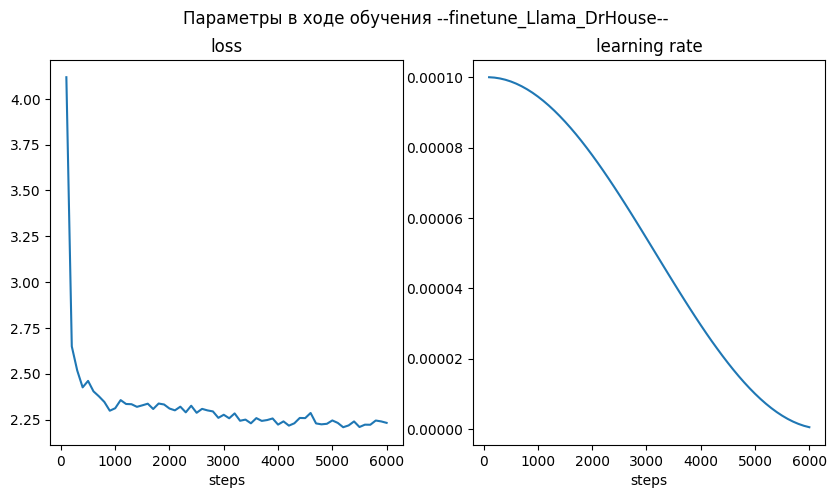

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Параметры в ходе обучения --finetune_Llama_DrHouse--')
axs[0].plot(step, loss)
axs[0].set_title("loss")
axs[0].set_xlabel("steps")
axs[1].plot(step, learning_rate)
axs[1].set_title("learning rate")
axs[1].set_xlabel("steps")
plt.savefig('data/fig1.png')

### finetune_Llama_DrHouse_v2

In [29]:
with open('finetune_Llama_DrHouse_v2/checkpoint-3000/trainer_state.json') as json_file:
    data = json.load(json_file)

step = []
learning_rate = []
loss = []
for i in data['log_history']:
    step.append(i['step'])
    learning_rate.append(i['learning_rate'])
    loss.append(i['loss'])

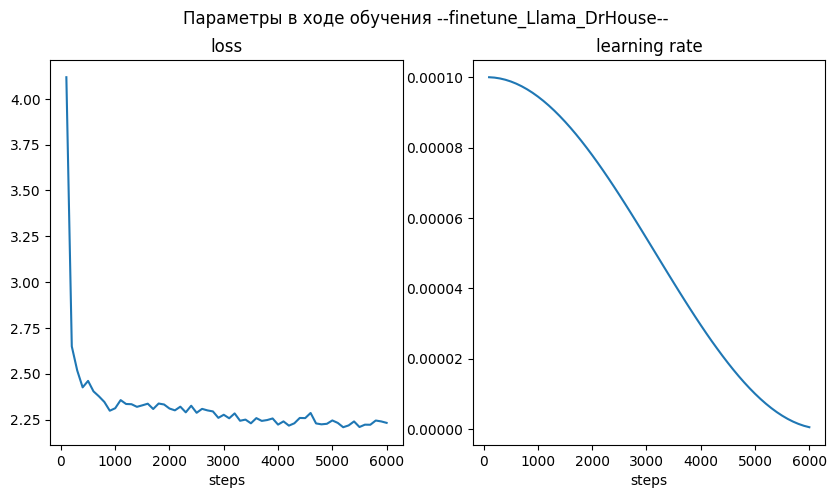

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Параметры в ходе обучения --finetune_Llama_DrHouse--')
axs[0].plot(step, loss)
axs[0].set_title("loss")
axs[0].set_xlabel("steps")
axs[1].plot(step, learning_rate)
axs[1].set_title("learning rate")
axs[1].set_xlabel("steps")
plt.savefig('data/fig2.png')

### finetune_Llama_DrHouse_v3

In [31]:
with open('finetune_Llama_DrHouse_v3/checkpoint-6000/trainer_state.json') as json_file:
    data = json.load(json_file)

step = []
learning_rate = []
loss = []
for i in data['log_history']:
    step.append(i['step'])
    learning_rate.append(i['learning_rate'])
    loss.append(i['loss'])

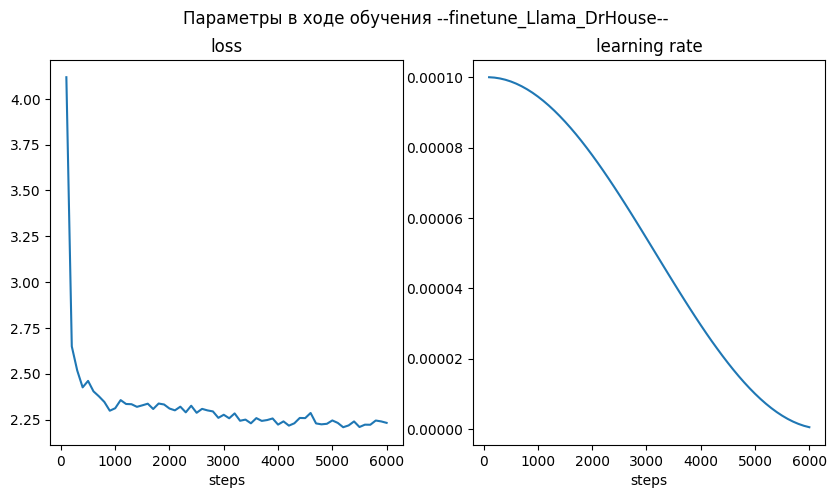

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Параметры в ходе обучения --finetune_Llama_DrHouse--')
axs[0].plot(step, loss)
axs[0].set_title("loss")
axs[0].set_xlabel("steps")
axs[1].plot(step, learning_rate)
axs[1].set_title("learning rate")
axs[1].set_xlabel("steps")
plt.savefig('data/fig3.png')